In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors

In [3]:
data = pd.read_csv('../00_data/blobs.csv')

In [4]:
data.head()

,Unnamed: 0,feature1,feature2,class
0,0,4.264632,-2.679361,1.0
1,1,-2.073791,-10.059099,1.0
2,2,-1.893893,4.504847,0.0
3,3,-0.529888,-3.059588,0.0
4,4,-2.958982,-0.156887,0.0


In [5]:
X = data[['feature1', 'feature2']].values
y = data['class'].values

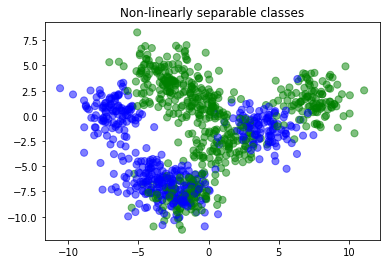

In [6]:
colors=['green','blue']
cmap = matplotlib.colors.ListedColormap(colors)
#Plot the figure
plt.figure()
plt.title('Non-linearly separable classes')
plt.scatter(X[:,0], X[:,1], c=y,
           marker= 'o', s=50,cmap=cmap,alpha = 0.5 )
plt.show()

- Before diving into deep neural network lets try to classify the data using simple logistic regression.

In [7]:
from sklearn.linear_model import LogisticRegression
lr_model = LogisticRegression()
lr_model = lr_model.fit(X, y)

In [26]:
def plot_decision_boundary( X, y, model, algo):
    plt.clf()
    # Set min and max values and give it some padding
    x_min, x_max = X[0, :].min() - 1, X[0, :].max() + 1
    y_min, y_max = X[1, :].min() - 1, X[1, :].max() + 1   
    colors=['blue','green']
    cmap = matplotlib.colors.ListedColormap(colors)   
    h = 0.01
    # Generate a grid of points with distance h between them
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    # Predict the function value for the whole grid
    A = model(np.c_[xx.ravel(), yy.ravel()])
    A = A.reshape(xx.shape)
    # Plot the contour and training examples
    plt.contourf(xx, yy, A, cmap="spring")
    plt.ylabel('x2')
    plt.xlabel('x1')
    plt.scatter(X[0, :], X[1, :], c=y, s=8,cmap=cmap)
    title = "Decision Boundary for {}:".format(algo)
    plt.title(title)
    plt.show()

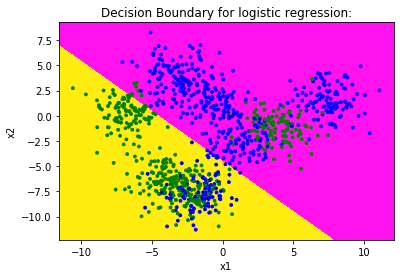

In [27]:
plot_decision_boundary(X.T,y,lambda x: lr_model.predict(x), 'logistic regression')

- Simple logistic regression poorly perfroms in classifying the data since the decision boundary is not able to effectively classify the two classes.
- Now build a deep neural network to classify the same data.  
Preparing the data:  
    - Transpose X so that rows represents the features and column represents samples.
    - Reshape data y to a row vector whose length equal to number of samples.

In [10]:
X_data = X.T
y_data = y.reshape(1, len(y))

Defining the layer dimension as an array  called **'layer_dims'**  with one input layer **equal to number of features**, **two hidden layer** with **nine nodes** each and **one final output layer** with** one node**.


In [11]:
layer_dims = [2, 9, 9, 1]

In [12]:
import tensorflow as tf

In [13]:
def placeholders(num_features):
  ##Start code here
  A_0 = tf.placeholder(dtype = tf.float64, shape = ([num_features,None]))
  Y = tf.placeholder(dtype = tf.float64, shape = ([1,None]))
  return A_0,Y
  ##End code

In [20]:
def initialize_parameters_deep(layer_dims):
  L = len(layer_dims)
  parameters = {}
  for l in range(1,L):
    parameters['W' + str(l)] = tf.Variable(initial_value=tf.random_normal([layer_dims[l], layer_dims[l-1]], dtype = tf.float64) * 0.01) 
    parameters['b' + str(l)] = tf.Variable(initial_value=tf.zeros([layer_dims[l],1], dtype=tf.float64))
 
  
  return parameters 

Defining functon named linear_forward_prop() to define forward propagation for a given layer.
- parameters: A_prev(output from previous layer), W(weigth matrix of current layer), b(bias vector for current layer),activation(type of activation to be used for out of current layer)  
- returns: A(output from the current layer)
- Use relu activation for hidden layers and for final output layer return the output unactivated i.e if activation is sigmoid

In [15]:
def linear_forward_prop(A_prev,W,b, activation):
  Z = tf.add(tf.matmul(W, A_prev), b)
  if activation == "sigmoid":
    A = Z
  elif activation == "relu":
    A = tf.nn.relu(Z)                                             #apply relu activation on Z using tf.nn.relu() function
  return A

Define forward propagation for entire network as l_layer_forward()
- Parameters: A_0(input data), parameters(dictionary of weights and bias)
- returns: A(output from final layer)

In [16]:
def l_layer_forwardProp(A_0, parameters):
  A = A_0
  L = len(parameters)//2
  for l in range(1,L):
    A_prev = A
    A = linear_forward_prop(A_prev,parameters['W' + str(l)],parameters['b' + str(l)], "relu")
  A_final = linear_forward_prop(A, parameters['W' + str(L)], parameters['b' + str(L)], "sigmoid" )
  return A_final

- Define the model as deep_layer_network()
- Parameters: X(input data), Y(output data), layer_dims, learning_rate, num_iter(number of iterations)
- returns: parameters ( dictionary of updated weights and bias)

In [17]:
# tf.compat.v1.disable_eager_execution()
# tf.compat.v1.disable_v2_behavior()

def deep_layer_network(X_data,y_data, layer_dims, learning_rate, num_iter):
  num_features = layer_dims[0]
  A_0, Y =   placeholders(num_features)            #call placeholder function to initialize placeholders A_0 and Y
  parameters =  initialize_parameters_deep(layer_dims)                                   #Initialse Weights and bias using initialize_parameters_deep() with layer_dims as parameters  
  Z_final = l_layer_forwardProp(A_0, parameters)                                       #call the function l_layer_forwardProp() to define the final output
  cost =  tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Z_final,labels=Y))                                         #define the mean cost using sigmoid cross entropy function
  train_net =  tf.train.GradientDescentOptimizer(learning_rate).minimize(cost)                                    #call tensorflow's gradient descent optimizer function with minimize cost  
  init = tf.global_variables_initializer()    
  
  with tf.Session() as sess:
    sess.run(init)
    for i in range(num_iter):
      _,c = sess.run([train_net, cost], feed_dict={A_0: X_data, Y: y_data})
      if i % 1000 == 0:
        print(c)
    #Stores your output in pickle file for validation. Donot modify
    with open('output/output1.pkl', 'wb') as file: 
      hexresult=gethex(round(c,2))
      pickle.dump(hexresult,file)
    params = sess.run(parameters)
  return params

In [21]:
parameters = deep_layer_network(X_data, y_data, layer_dims, 0.3, 10000)    #fill the parameters 

0.6931456352121004
0.37976824712408
0.33731409439567267
0.2941334719284613
0.28872637113110705
0.28630672779844457
0.28467356109587105
0.2810581150064877
0.28014806120819447
0.27949786820124406


In [22]:
def predict(A_0, parameters):
  with tf.Session() as sess:
    Z = l_layer_forwardProp(A_0, parameters)
    A = sess.run(tf.round(tf.sigmoid(Z)))
  return A

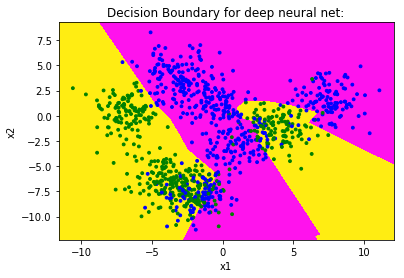

In [28]:
plot_decision_boundary(X_data,y,lambda x: predict(x.T,parameters),'deep neural net')